# Leverage LLamaIndex with VertexAI Vector Search to perform question answering RAG

<a href="https://colab.research.google.com/github/noabenefraim/llamaindex_rag/blob/main/llamaindex_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

This notebook will go over how to create a RAG framework using LlamaIndex and VertexAI Vector Search effectively.

LlamaIndex is used to parse, chunk, and embed the input data using Gemini Text Embedding models. We use store the parsed data in a VertexAI Vector Search index that will searched against during inference to retrieve context to augment prompts for question answering task.

### Objectives
This notebook provides a guide to building a questions answering system using retrieval augmented generation (RAG) framework that leverages LLamaIndex for data ingestion and Vector Store creation.

You will complete the following tasks:

1. Set up Google Cloud resources required: GCS Bucket and Vertex AI Vector Search index and deployed endpoint
2. Ingest, parse, chunk, and embed data using LlamaIndex with Gemini Text Embedding models.
3. Search the vector store with an incoming text queries to find similar text data that can be used as context in the prompt
4. Generate answer to the user query using Gemini Pro Model.

### LlamaIndex

LlamaIndex is a data framework specifically designed to enhance the capabilities of Large Language Models (LLMs) like Gemini-Pro. It addresses the limitations of LLMs in handling and retrieving information from private or domain-specific data sources.

LlamaIndex enables seamless integration with diverse data sources, and enhances the ability to retrieve and utilize relevant information. Therefore it is a great candidate to build RAG frameworks on top of.

Key reasons to use LlamaIndex:

1. Efficient Data Ingestion and Indexing:

    Diverse Data Sources: LlamaIndex simplifies the process of loading data from various sources, including APIs, PDFs, SQL databases, and more. It provides a standardized way to ingest and transform data into a format suitable for LLMs.

    Structured Indexing: LlamaIndex creates structured indexes (vector indexes, keyword indexes, etc.) over the ingested data. This allows LLMs to efficiently retrieve relevant information based on queries or prompts.

2. Enhanced Retrieval and Contextual Understanding:

    Query Engine: LlamaIndex offers a flexible query engine that enables LLMs to search and retrieve information from indexed data based on natural language queries. It can combine keyword-based search with semantic understanding for more accurate results.
    Contextual Augmentation: LlamaIndex can augment LLMs with relevant context from the indexed data, improving the quality and accuracy of generated responses.

3. Streamlined Development of LLM Applications:

    Simplified Integration: LlamaIndex simplifies the integration of LLMs with external data sources, reducing the complexity of building custom LLM applications.

    Abstraction of Complexities: It abstracts away many of the technical challenges associated with working with LLMs, such as data preprocessing, indexing, and retrieval, allowing developers to focus on the core application logic.
    
    Rapid Prototyping: LlamaIndex facilitates rapid prototyping and experimentation with different data sources and LLM configurations, accelerating the development cycle.

4. Extensibility and Customization:

    Modular Design: LlamaIndex is designed with modularity in mind, allowing you to customize and extend its functionality to suit your specific use case.

    Community-Driven Extensions: It has a growing community of developers contributing new data connectors, index types, and query strategies.


### VertexAI
This notebook utilizes two main components of VertexAI:
1. Gemini models
2. VertexAI Vector Search

The Gemini models used are the Text Embedding model and Gemini-Pro. The embedding model is used to convert textual data into numerical vectors that can be stored and searched against. Gemini-Pro is used to generate the completion using the RAG prompt as input and returning an answer to the query in the specified format.

VertexAI Vector Search is used to search for semantically similar or relevant items. Semantic matching can be simplified into a few steps. To utilize Vector Search, first you must generate embeddings then upload and link your data to Vector Search. Then you can create an index to run queries against to get recommendations or results.

### RAG
Retrieval augmented generation (RAG) has become a popular paradigm for enabling LLMs to access external data and also as a mechanism for grounding to mitigate against hallucinations.

In this notebook, you will learn how to perform RAG where you will perform Q&A over a document and explore how different prompt formats impact RAG results.


### Costs
This tutorial uses billable components of Google Cloud:

+ Vertex AI
+ GCS Bucket

Learn about Vertex AI pricing and use the Pricing Calculator to generate a cost estimate based on your projected usage

## Getting Started

### Authenticate your notebook enviorment

This notebook expects the following resources to exists:
+ initialized Google Cloud project 
+ VertexAI API enabled
+ existing VPC/Subnet 

In [3]:
PROJECT_ID = "" #TODO add your project id here # @param {type:"string"}
REGION = "" #TODO add your project region here # @param {type:"string"}
GCS_BUCKET = "llama_gcs_bucket"  # @param {type:"string"}
VS_INDEX_NAME = "llamaindex_doc_index"  # @param {type:"string"}
VS_INDEX_ENDPOINT_NAME = "llamaindex_doc_endpoint"  # @param {type:"string"}
DOC_FOLDER = "./data"  # @param {type:"string"}

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [5]:
import vertexai

vertexai.init(project=PROJECT_ID, location=REGION)

### Setting up the Environment
Install dependencies

In [6]:
!pip install google-cloud-aiplatform \
  google-cloud-storage \
  llama-index \
  llama-index-embeddings-vertex \
  llama-index-llms-vertex \
  llama-index-vector_stores-vertexaivectorsearch \
  langchain-community \
  llama-index-llms-langchain \
  llama-index-llms-fireworks \
  langchainhub -q

Set up imports

In [6]:
#Imports
import os
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    Settings,
    PromptTemplate,
    SummaryIndex
)
from llama_index.embeddings.vertex import VertexTextEmbedding
from llama_index.llms.vertex import Vertex
from google.cloud import aiplatform
from google.cloud import storage
from llama_index.core.prompts import LangchainPromptTemplate
from langchain import hub
from llama_index.core.agent import ReActAgent
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.objects import ObjectIndex
from llama_index.vector_stores.vertexaivectorsearch import VertexAIVectorStore


In [ ]:
!gcloud config set project {PROJECT_ID}
#!gcloud auth application-default login

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Using llama index

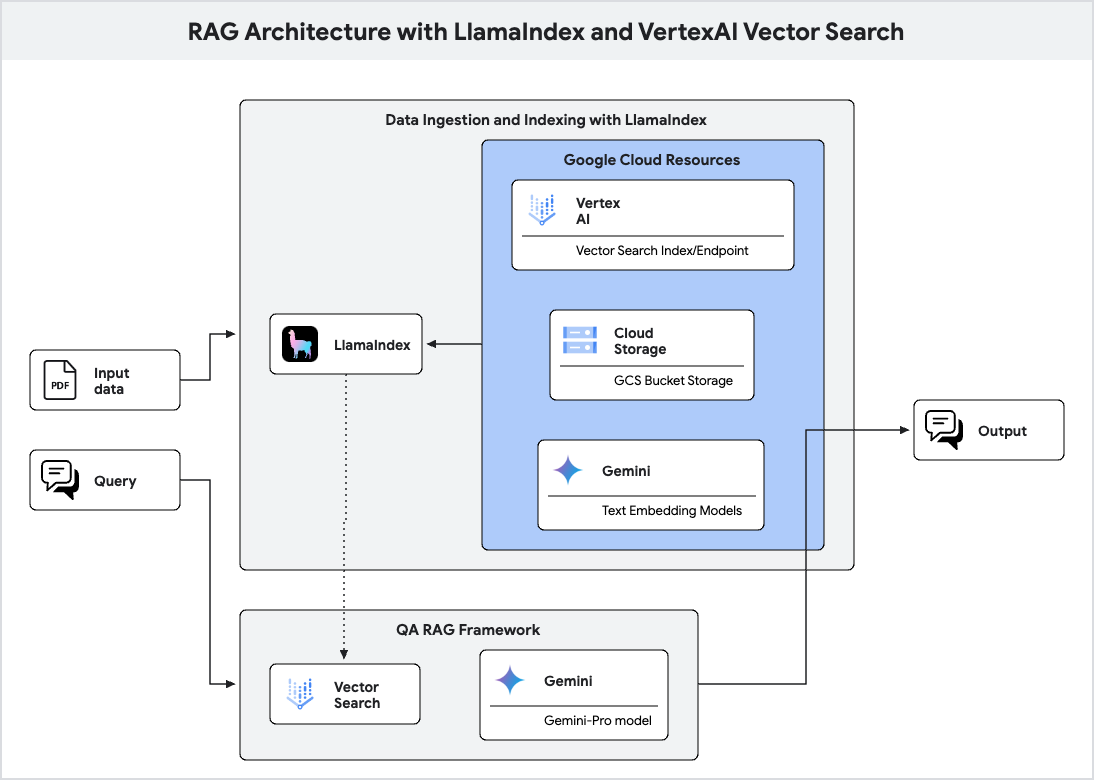

In [9]:
from IPython.display import Image
Image(filename="llama/run-llama/run_llama/LlamaRAG.png")

### Investigate sample data

Refer to document 04a02.pdf

This document describes the importance of stable power grids in Japan, highlighting the recent failure of a generator step-up transformer at the Nakoso Power Station and the rapid restoration response undertaken to maintain power supply stability.

We will use this pdf moving forward.

## Set Up: VertexAI Index and Endpoint

This section goes over how to set up the necessary cloud resources to run the RAG framework. You will be performing the following steps:

1. Creating a GCP bucket
2. Creating a VertexAI Vector Search Index
3. Creating a VertexAI Vector Search endpoint
4. Deploying a VertexAI Vector Search endpoint



In [5]:
def create_bucket_class_location(bucket_name):
    """
    Create a new bucket in the US region with the coldline storage
    class.
    """

    storage_client = storage.Client()

    #Searching for existing GCS bucket
    for bucket in storage_client.list_buckets():
        if bucket.name==bucket_name:
            print(
                f"GCS Bucket {bucket_name} exists already in resource."
            )
            return bucket

    #Creating new bucket
    bucket = storage_client.bucket(bucket_name)
    bucket.storage_class = "STANDARD"
    new_bucket = storage_client.create_bucket(bucket, location=REGION)

    print(
        "Created bucket {} in {} with storage class {}".format(
            new_bucket.name, new_bucket.location, new_bucket.storage_class
        )
    )

    return new_bucket

def create_vertex_ai_search_index(index_name, index_dimensions):
    """
    Creates a VertexAI Search Index
    NOTE : This operation can take upto 30 minutes
    """

    # check if index exists
    index_names = [
        index.resource_name
        for index in aiplatform.MatchingEngineIndex.list(
            filter=f"display_name={index_name}"
        )
    ]

    if len(index_names) == 0:
        print(f"Creating Vector Search index {index_name} ...")
        vs_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
            display_name=index_name,
            dimensions=index_dimensions,
            distance_measure_type="DOT_PRODUCT_DISTANCE",
            shard_size="SHARD_SIZE_SMALL",
            index_update_method="STREAM_UPDATE",  # allowed values BATCH_UPDATE , STREAM_UPDATE,
            approximate_neighbors_count = 5
        )
        print(
            f"Vector Search index {vs_index.display_name} created with resource name {vs_index.resource_name}"
        )
    else:
        vs_index = aiplatform.MatchingEngineIndex(index_name=index_names[0])
        print(
            f"Vector Search index {vs_index.display_name} exists with resource name {vs_index.resource_name}"
        )

    return vs_index

def create_vertexai_search_endpoint(endpoint_name):
    """
    Creates a VertexAI Search endpoint.
    """
    endpoint_names = [
        endpoint.resource_name
        for endpoint in aiplatform.MatchingEngineIndexEndpoint.list(
            filter=f"display_name={endpoint_name}"
        )
    ]

    if len(endpoint_names) == 0:
        print(
            f"Creating Vector Search index endpoint {endpoint_name} ..."
        )
        vs_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
            display_name=endpoint_name, public_endpoint_enabled=True
        )
        print(
            f"Vector Search index endpoint {vs_endpoint.display_name} created with resource name {vs_endpoint.resource_name}"
        )
    else:
        vs_endpoint = aiplatform.MatchingEngineIndexEndpoint(
            index_endpoint_name=endpoint_names[0]
        )
        print(
            f"Vector Search index endpoint {vs_endpoint.display_name} exists with resource name {vs_endpoint.resource_name}"
        )

    return vs_endpoint

def deploy_vertexai_search_endpoint(vs_index, vs_endpoint, index_name):
    """
    Deploys a VertexAI search endpoint.
    """
    # check if endpoint exists
    index_endpoints = [
        (deployed_index.index_endpoint, deployed_index.deployed_index_id)
        for deployed_index in vs_index.deployed_indexes
    ]

    if len(index_endpoints) == 0:
        print(
            f"Deploying Vector Search index {vs_index.display_name} at endpoint {vs_endpoint.display_name} ..."
        )
        vs_deployed_index = vs_endpoint.deploy_index(
            index=vs_index,
            deployed_index_id=index_name,
            display_name=index_name,
            machine_type="e2-standard-16",
            min_replica_count=1,
            max_replica_count=1,
        )
        print(
            f"Vector Search index {vs_index.display_name} is deployed at endpoint {vs_deployed_index.display_name}"
        )
    else:
        vs_deployed_index = aiplatform.MatchingEngineIndexEndpoint(
            index_endpoint_name=index_endpoints[0][0]
        )
        print(
            f"Vector Search index {vs_index.display_name} is already deployed at endpoint {vs_deployed_index.display_name}"
        )

    return vs_deployed_index

In [6]:
def setup():
    GCS_BUCKET_URI = f"gs://{GCS_BUCKET}"

    # The number of dimensions for the gecko text embeddings is 768
    VS_DIMENSIONS = 768
    # Vertex AI Vector Search Index configuration

    aiplatform.init(project=PROJECT_ID, location=REGION)

    new_bucket = create_bucket_class_location(GCS_BUCKET)
    vs_index = create_vertex_ai_search_index(VS_INDEX_NAME, VS_DIMENSIONS)
    vs_endpoint = create_vertexai_search_endpoint(VS_INDEX_ENDPOINT_NAME)
    vs_deployed_index = deploy_vertexai_search_endpoint(vs_index, vs_endpoint, VS_INDEX_NAME)

    return new_bucket, vs_index, vs_endpoint, vs_deployed_index


## Ingest data using Llama-Index into VertexAI Vector Search

The following section leverages LlamaIndex to ingest, chunk, and embed the PDF data to be connected to the VertexAI Vector Store.

At the end of this section you will be ready to query against the Vector Store to find relevant context.

In [6]:
def initialize_llm_and_storage(vs_index, vs_endpoint):
    """
    Initializes VertexAI Vector Store given a VertexAI Search index and deployed endpoint.
    Configures embedding and LLMs models to be gecko and Gemini.
    """
    # setup storage
    vector_store = VertexAIVectorStore(
        project_id=PROJECT_ID,
        region=REGION,
        index_id=vs_index.resource_name,
        endpoint_id=vs_endpoint.resource_name,
        gcs_bucket_name=GCS_BUCKET,
    )

    # set storage context
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    gemini_embedding_model = VertexTextEmbedding("text-embedding-004")
    llm = Vertex("gemini-pro")

    Settings.embed_model = gemini_embedding_model
    Settings.llm=llm

    return storage_context

def ingest_document():
    '''
    Using SimpleDirectoryReader, which creates documents out of every file in a given directory. It is built in to LlamaIndex and can read a variety of formats including Markdown, PDFs, Word documents, PowerPoint decks, images, audio and video.
    '''
    documents = SimpleDirectoryReader(DOC_FOLDER).load_data()
    return documents

Setup vertex AI vector search if it does not exist, otherwise return an endpoint for the deployed index, which will be used for the llamaindex retriever

In [11]:
(bucket,vs_index, vs_endpoint, dply) = setup()
storage_context = initialize_llm_and_storage(vs_index, vs_endpoint)
docs = ingest_document()

GCS Bucket llama_gcs_bucket exists already in resource.
Vector Search index llamaindex_doc_index exists with resource name projects/726844691572/locations/us-central1/indexes/4322035073252589568
Vector Search index endpoint llamaindex_doc_endpoint exists with resource name projects/726844691572/locations/us-central1/indexEndpoints/734355020098568192
Vector Search index llamaindex_doc_index is already deployed at endpoint llamaindex_doc_endpoint


## Perform Q/A RAG

This section peforms the RAG prompt and returns an answer to the user query. To explore RAG frameworks we will look at 3 different options:

1. Using the built-in RAG prompt provided by LlamaIndex
2. Connecting a LangChain RAG template
3. Creating a custom few-shot example RAG template.

For each option, you will see the current text prompt structure and the generated output.

In [13]:
# Setting up helper functions

def display_prompt_dict(prompts_dict):
    """
    Used to display the underlying text prompt used for RAG.
    """
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k}<br>" f"**Text:** <br>"
        print(text_md)
        print(p.get_template())
        print("\n\n")

def display_and_run_prompt(query_engine, query_str):
    """
    Displays the current RAG prompt used and runs the query against the RAG workflow.
    """
    print("----Displaying current prompt dictionary----\n")
    prompts_dict = query_engine.get_prompts()
    display_prompt_dict(prompts_dict)

    response = query_engine.query(query_str)
    print(f"Response:")
    print("-" * 80)
    print(response.response)
    print("-" * 80)
    print(f"Source Documents:")
    print("-" * 80)
    for source in response.source_nodes:
        print(f"Sample Text: {source.text[:200]}")
        print(f"Relevance score: {source.get_score():.3f}")
        print(f"File Name: {source.metadata.get('file_name')}")
        print(f"Page #: {source.metadata.get('page_label')}")
        print(f"File Path: {source.metadata.get('file_path')}")
        print("-" * 80)

### LlamaIndex Built-in RAG

In [14]:
def llama_built_in_prompt(query_engine, query_str):
    display_and_run_prompt(query_engine, query_str)

### Templeted RAG through LangChain

In [19]:
def langchain_rag_prompt(query_engine, query_str):
    langchain_prompt = hub.pull("rlm/rag-prompt")


    langchain_prompt_template = LangchainPromptTemplate(
        template=langchain_prompt,
        template_var_mappings={"query_str": "question", "context_str": "context"},
    )

    query_engine.update_prompts(
        {"response_synthesizer:text_qa_template": langchain_prompt_template}
    )

    display_and_run_prompt(query_engine, query_str)

### Custom RAG Implementation

This custom RAG prompt highlights two important prompt engineering techniques:

__Few-shot examples:__ Providing the model with a few examples of the desired input-output behavior helps guide the model's response, effectively demonstrating the task and the expected format. This is particularly useful when the task is complex or requires a specific style of output.

__Grounding the output:__ Instructing the model to base its answer on the retrieved documents and to provide justification for the answer ensures that the response is factually grounded and relevant to the context. This is crucial for maintaining accuracy and preventing the model from generating responses that are either irrelevant or factually incorrect.


In [22]:
def custom_few_shot_prompt(query_engine, query_str):
    """
    Generating custom few shot prompt to show the desired output format and prevent hallucination by including reasoning in the response.
    """

    qa_prompt_custom_string= """\
    Context information is below.
    ---------------------
    {context_str}
    ---------------------
    Given the context information and not prior knowledge, answer the query asking about citations over different topics.

    Please output your answer in the following JSON format:
    JSON Output: [
    "answer": 'This is the answer to the question',
    "justification": 'This is the reasoning or evidence supporting the answer given the provided context'
    ]

    Example query and JSON output:
    Query: Who are the authors of the paper?
    JSON Output: [
    "answer": "The authors are Hikaru Fujita, Masaru Kashiwakura, Akihiro Kawagoe, Hisaki Hamamoto, Tetsuo Niitsuma, and Yuzuru Mitani."
    "justification": "The authors are listed on the first and last page in order."
    ]

    Query: When was there a failure at the Nakoso Power Station?
    JSON Output: [
    "answer": "September  16,  2021",
    "justification": "In the context provided it states: It was in this context
    that  on  September  16,  2021,  a  failure  due  to  aging  forced  the  emergency  stop  of  the
    unit No. 8 generator step-up transformer (built in 1981) at the Nakoso Power Station of
    Jōban Joint Power Co., Ltd. "
    ]

    Query: {query_str}
    Answer:
    """

    custom_RAG_template = PromptTemplate(
        template=qa_prompt_custom_string
    )

    query_engine.update_prompts(
        {"response_synthesizer:text_qa_template": custom_RAG_template}
    )

    display_and_run_prompt(query_engine, query_str)

In [20]:
def index_and_query_documents(documents, storage_context):
    """
    Sets up vector store index to query against for a RAG pattern.
    """
    #Using gemini embedding models
    vector_index = VectorStoreIndex.from_documents(
        documents, storage_context=storage_context
    )

    #Set up a query engine
    query_engine = vector_index.as_query_engine()

    query = "what is minimum reserve rate of power?"
    print("*******Option 1: LlamaIndex Built-In Prompt*******")
    llama_built_in_prompt(query_engine, query)
    print("*******Option 2: LangChain Template RAG Prompt*******")
    langchain_rag_prompt(query_engine, query)
    print("*******Option 3: Custom Few-Shot Prompt*******")
    custom_few_shot_prompt(query_engine,query)


In [ ]:
# Run the RAG workflow for the llama-index built in prompt, templated LangChain prompt, and custom few-shot prompt
vector_idx = index_and_query_documents(docs, storage_context)


## Multi-Document RAG

So far we have established how to set up set up the necessary Google Cloud resources, set up a LlamaIndex agent, and customize prompts for RAG question answering. 

In this section we will cover Multi-Document Agents that can effectively answer different set of questions over a larger set of documents. Questions can include QA and summaries over a individual document or across documents. 

To do this we will follow these steps:

+ setup a "document agent" over each Document: each doc agent can do QA/summarization within its doc
+ setup a top-level agent over this set of document agents: tool retrieval and answer over the set of tools responses to answer a question

### Add more documents

In [10]:
def ingest_multi_document():
    import os
    doc_dict = {}

    for filename in os.listdir(DOC_FOLDER):
        doc_dict[filename] = SimpleDirectoryReader(
            input_files=[os.path.join(DOC_FOLDER, filename)]
        ).load_data()

    return doc_dict

In [ ]:
# Load documents 
multi_docs = ingest_multi_document()

### Build Document Level Agents

First we will build document agents for each document. 

We will create two query engines, one for semantic search and one for summarization, for each document. These query engines will be converted into tools that can be passed to a function calling agent.

We will be using the ReAct agent (short for "Reasoning and Acting"). This agent is an LLM-powered agent designed to perform complex tasks over your data. It operates in both "read" and "write" modes, making it a versatile tool for various applications. 

In [81]:
def build_document_level_agents(documents, storage_context):
    """
    Sets up a vector search and summarization tool for each document. Generates an agent for each documents based on tools.
    """

    node_parser = SentenceSplitter()

    #Build agents dictionary
    agents = {}
    query_engines = {}

    for idx, doc_title in enumerate(documents):
        
        #A Node represents a "chunk" of a source Document, whether that is a text chunk, an image, or other. Similar to Documents, they contain metadata and relationship information with other nodes.
        nodes = node_parser.get_nodes_from_documents(documents[doc_title], show_progress=True)

        #Build query index
        vector_index = VectorStoreIndex.from_documents(
            documents[doc_title], storage_context=storage_context
        )
        #Build summary index
        summary_index = SummaryIndex(nodes)

        #Define engines
        vector_query_engine = vector_index.as_query_engine()
        summary_query_engine = summary_index.as_query_engine()

        #Define tools
        query_engine_tools = [
            QueryEngineTool(
                query_engine=vector_query_engine,
                metadata=ToolMetadata(
                    name="vector_tool",
                    description=(
                        "Useful for questions related to specific aspects of"
                        f" {doc_title}."
                    ),
                ),
            ),
            QueryEngineTool(
                query_engine=summary_query_engine,
                metadata=ToolMetadata(
                    name="summary_tool",
                    description=(
                        "Useful for any requests that require a holistic summary"
                        f" of EVERYTHING about {doc_title}. For questions about"
                        " more specific sections, please use the vector_tool."
                    ),
                ),
            ),
        ]

        #Build agent
        llm = Vertex("gemini-pro")
        agent = ReActAgent.from_tools(
            query_engine_tools,
            llm=llm,
            verbose=True,
            system_prompt=f"""\
            You are a specialized agent designed to answer queries about {doc_title}.
            You must ALWAYS use at least one of the tools provided when answering a question; do NOT rely on prior knowledge.\
            """,
            )

        agents[doc_title] = agent
        query_engines[doc_title] = vector_index.as_query_engine(
            similarity_top_k=2
        )

    return agents


In [82]:
agents = build_document_level_agents(multi_docs, storage_context)

Parsing nodes: 100%|██████████| 6/6 [00:00<00:00, 637.95it/s]


Upserting datapoints MatchingEngineIndex index: projects/726844691572/locations/us-central1/indexes/4322035073252589568
MatchingEngineIndex index Upserted datapoints. Resource name: projects/726844691572/locations/us-central1/indexes/4322035073252589568


Parsing nodes: 100%|██████████| 3/3 [00:00<00:00, 737.65it/s]


Upserting datapoints MatchingEngineIndex index: projects/726844691572/locations/us-central1/indexes/4322035073252589568
MatchingEngineIndex index Upserted datapoints. Resource name: projects/726844691572/locations/us-central1/indexes/4322035073252589568


Parsing nodes: 100%|██████████| 9/9 [00:00<00:00, 1129.25it/s]


Upserting datapoints MatchingEngineIndex index: projects/726844691572/locations/us-central1/indexes/4322035073252589568
MatchingEngineIndex index Upserted datapoints. Resource name: projects/726844691572/locations/us-central1/indexes/4322035073252589568


Parsing nodes: 100%|██████████| 4/4 [00:00<00:00, 986.20it/s]


Upserting datapoints MatchingEngineIndex index: projects/726844691572/locations/us-central1/indexes/4322035073252589568
MatchingEngineIndex index Upserted datapoints. Resource name: projects/726844691572/locations/us-central1/indexes/4322035073252589568


### Build Top Level Agent

We build a top-level agent that can orchestrate across the different document agents to answer any user query. This agent takes in all document agents as tools that were built above. 



In [84]:
def build_top_level_agent(agents):
    #This agent takes in all document agents as tools
    all_tools = []

    for filename in os.listdir(DOC_FOLDER):
        summary = (
        f"This content contains a research paper articles about {filename}. Use"
        f" this tool if you want to answer any questions about {filename}.\n"
        )
        doc_tool = QueryEngineTool(
            query_engine=agents[filename],
            metadata=ToolMetadata(
                name=f"tool_{filename}".rstrip(".pdf"),
                description=summary,
            ),
        )
        
        all_tools.append(doc_tool)


    #define an "object" index and retriever over these tools
    obj_index = ObjectIndex.from_objects(
        all_tools,
        index_cls=VectorStoreIndex,
    )   

    #Create top level agent
    top_agent = ReActAgent.from_tools(
        tool_retriever=obj_index.as_retriever(similarity_top_k=3),
        system_prompt=""" \
            You are an agent designed to answer queries about energy systems.
            Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

            """,
        verbose=True,
    )
    
    return top_agent

In [85]:
top_level_agent = build_top_level_agent(agents)

### Perform Multi-Document QA Rag

Know we can query the top level agent. We will experiment with various question types that require lookup in individual documents and across multiple documents.

In [86]:
#QA over a specific doc
response = top_level_agent.query("Tell me about the Higashi-Shimizu Substation of Chubu Electric Power Grid")

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: tool_04a04
Action Input: {'input': 'Higashi-Shimizu Substation'}
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool
Action Input: {'input': 'Higashi-Shimizu Substation'}
Observation: ## Higashi-Shimizu Substation: A Compact Powerhouse

The Higashi-Shimizu Substation is a testament to efficient engineering and collaboration. Located on a steep hillside with limited space, the substation houses three frequency converters (FCs): No. 1 FC, No. 2 FC, and No. 3 FC. 

**Key Features:**

* **Compact Design:** Despite the limited space, the substation boasts a compact design that optimizes equipment layout while maintaining required electrical and maintenance clearances.
* **Redundant Control and Protection Systems:** The MACH system ensures reliable operation with redundant control and protection compute

In [89]:
# summaries across documents 
response = top_level_agent.query("What are all projects introduced after the Great East Japan Earthquake?")

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: tool_04a01
Action Input: {'input': 'What are all projects introduced after the Great East Japan Earthquake?'}
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: summary_tool
Action Input: {'input': 'What are all projects introduced after the Great East Japan Earthquake?'}
Observation: ## Projects introduced after the Great East Japan Earthquake:

* **Enhancement of Higashi-Shimizu Substation of Chubu Electric Power Grid by VSC Technology:** This project aims to expand the grid interconnection capacity between the different frequencies in eastern Japan (50 Hz) and western Japan (60 Hz) by installing two blocks of frequency converter systems at the Higashi-Shimizu Substation. The project is expected to be completed by the end of FY2027.
* **Hida-Shinano HVDC link:** This project increased the interconnection c

In [91]:
#cross document QA
response = top_level_agent.query("List out all the technologies that are used to stabilize the power system?")

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: tool_04a04
Action Input: {'input': 'List out all the technologies that are used to stabilize the power system?'}
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: summary_tool
Action Input: {'input': 'List out all the technologies that are used to stabilize the power system?'}
Observation: ## Technologies used to stabilize the power system:

Based on the provided context, here are the technologies used to stabilize the power system:

* **HVDC (High-Voltage Direct Current) technology:** This technology allows for the transmission of large amounts of electricity over long distances with minimal losses. It also enables the integration of renewable energy sources and the interconnection of grids, which helps to stabilize the overall power system.
* **HVDC Classic and HVDC Light:** These are two specific types o

In [94]:
response = top_level_agent.query("Explain to me what the building blocks of the MACH control and protection system and where it is used.")

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: tool_04a04
Action Input: {'input': 'Explain to me what the building blocks of the MACH control and protection system and where it is used.'}
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool
Action Input: {'input': 'Explain to me what the building blocks of the MACH control and protection system and where it is used.'}
Observation: The MACH control and protection system is a modular system that can control all types and generations of HVDC systems. It is used to monitor, control, and protect HVDC systems. The system is made up of several different building blocks, including:

* The main computer system, which consists of three different products: the PS700, a high-performance server type computer with 8–12 cores; the PS935, an 8-core DSP platform; and the PS775 redundancy changeover unit.
* The 

## Cleaning up
To clean up all Google Cloud resources used in this project, you can delete the Google Cloud project you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.